In [25]:
import pandas as pd
import random
import numpy  as np
import copy
import os
from matplotlib import pyplot as plt

In [26]:
# Function: Tour Distance
def distance_calc(Xdata, city_tour):
    distance = 0
    for k in range(0, len(city_tour[0])-1):
        m = k + 1
        distance = distance + Xdata[city_tour[0][k]-1, city_tour[0][m]-1]            
    return distance

In [27]:
# Function: Euclidean Distance 
def euclidean_distance(x, y):       
    distance = 0
    for j in range(0, len(x)):
        distance = (x[j] - y[j])**2 + distance   
    return distance**(1/2) 

In [28]:
# Function: Initial Seed
def seed_function(Xdata):
    seed = [[],float("inf")]
    sequence = random.sample(list(range(1,Xdata.shape[0]+1)), Xdata.shape[0])
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed

In [29]:
# Function: Build Distance Matrix
def build_distance_matrix(coordinates):
   a = coordinates
   b = a.reshape(np.prod(a.shape[:-1]), 1, a.shape[-1])
   return np.sqrt(np.einsum('ijk,ijk->ij',  b - a,  b - a)).squeeze()

In [30]:
# Function: Tour Plot
def plot_tour_distance_matrix (Xdata, city_tour):
    m = np.copy(Xdata)
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            m[i,j] = (1/2)*(Xdata[0,j]**2 + Xdata[i,0]**2 - Xdata[i,j]**2)    
    w, u = np.linalg.eig(np.matmul(m.T, m))
    s = (np.diag(np.sort(w)[::-1]))**(1/2) 
    coordinates = np.matmul(u, s**(1/2))
    coordinates = coordinates.real[:,0:2]
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

In [31]:
# Function: Tour Plot
def plot_tour_coordinates (coordinates, city_tour):
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

In [32]:
# Function: Rank Cities by Distance
def ranking(Xdata, city = 0):
    rank = np.zeros((Xdata.shape[0], 2)) # ['Distance', 'City']
    for i in range(0, rank.shape[0]):
        rank[i,0] = Xdata[i,city]
        rank[i,1] = i + 1
    rank = rank[rank[:,0].argsort()]
    return rank

In [33]:
# Function: RCL
def restricted_candidate_list(Xdata, greediness_value = 0.5):
    seed = [[],float("inf")]
    sequence = []
    sequence.append(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
    count = 1
    for i in range(0, Xdata.shape[0]):
        count = 1
        rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if (rand > greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            while next_city in sequence:
                count = np.clip(count+1,1,Xdata.shape[0]-1)
                next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            sequence.append(next_city)
        elif (rand <= greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0]
            while next_city in sequence:
                next_city = int(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
            sequence.append(next_city)
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed

In [34]:
# Function: 2_opt
def local_search_2_opt(Xdata, city_tour):
    tour = copy.deepcopy(city_tour)
    best_route = copy.deepcopy(tour)
    seed = copy.deepcopy(tour)  
    for i in range(0, len(tour[0]) - 2):
        for j in range(i+1, len(tour[0]) - 1):
            best_route[0][i:j+1] = list(reversed(best_route[0][i:j+1]))           
            best_route[0][-1]  = best_route[0][0]                          
            best_route[1] = distance_calc(Xdata, best_route)           
            if (best_route[1] < tour[1]):
                tour[1] = copy.deepcopy(best_route[1])
                for n in range(0, len(tour[0])): 
                    tour[0][n] = best_route[0][n]          
            best_route = copy.deepcopy(seed) 
    return tour

In [35]:
def greedy_randomized_adaptive_search_procedure(Xdata, city_tour, iterations = 50, rcl = 25, greediness_value = 0.5):
    count = 0
    best_solution = copy.deepcopy(city_tour)
    while (count < iterations):
        rcl_list = []
        for i in range(0, rcl):
            rcl_list.append(restricted_candidate_list(Xdata, greediness_value = greediness_value))
        candidate = int(random.sample(list(range(0,rcl)), 1)[0])
        city_tour = local_search_2_opt(Xdata, city_tour = rcl_list[candidate])
        while (city_tour[0] != rcl_list[candidate][0]):
            rcl_list[candidate] = copy.deepcopy(city_tour)
            city_tour = local_search_2_opt(Xdata, city_tour = rcl_list[candidate])
        if (city_tour[1] < best_solution[1]):
            best_solution = copy.deepcopy(city_tour) 
        count = count + 1
        print("Iteration =", count, "-> Distance =", best_solution[1])
    print("Best Solution =", best_solution)
    return best_solution

Iteration = 1 -> Distance = 1922.3293587909286
Iteration = 2 -> Distance = 1922.3293587909286
Iteration = 3 -> Distance = 1922.3293587909286
Iteration = 4 -> Distance = 1922.3293587909286
Iteration = 5 -> Distance = 1922.3293587909286
Best Solution = [[5, 9, 12, 16, 4, 1, 13, 7, 8, 17, 6, 14, 15, 3, 11, 10, 2, 5], 1922.3293587909286]


C:\Users\Ayoub\AppData\Local\Temp/ipykernel_6312/1141633181.py:8: RuntimeWarning: invalid value encountered in sqrt
  s = (np.diag(np.sort(w)[::-1]))**(1/2)


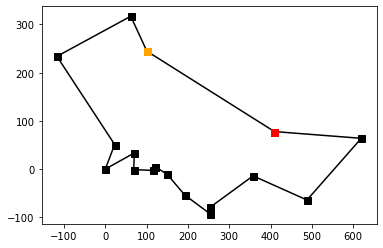

In [36]:
#Première phase: phase de construction
# Load File - A Distance Matrix (17 cities,  optimal = 1922.33)
X = pd.read_csv('mydatabase01.txt', sep = '\t') 
X = X.values
# Start a Random Seed
seed = seed_function(X)
# Call the Function
lsgrasp = greedy_randomized_adaptive_search_procedure(X, city_tour = seed, iterations = 5, rcl = 5, greediness_value = 0.5)
# Plot Solution. Red Point = Initial city; Orange Point = Second City # The generated coordinates (2D projection) are aproximated, depending on the data, the optimum tour may present crosses
plot_tour_distance_matrix(X, lsgrasp)

Iteration = 1 -> Distance = 8242.586417914132
Iteration = 2 -> Distance = 8078.842361614312
Iteration = 3 -> Distance = 8078.842361614312
Iteration = 4 -> Distance = 7811.73425690421
Iteration = 5 -> Distance = 7544.365901904087
Iteration = 6 -> Distance = 7544.365901904087
Iteration = 7 -> Distance = 7544.365901904087
Iteration = 8 -> Distance = 7544.365901904087
Iteration = 9 -> Distance = 7544.365901904087
Iteration = 10 -> Distance = 7544.365901904087
Best Solution = [[31, 22, 1, 49, 32, 45, 19, 41, 8, 9, 10, 43, 33, 51, 11, 52, 14, 13, 47, 26, 27, 28, 12, 25, 4, 6, 15, 5, 24, 48, 38, 37, 40, 39, 36, 35, 34, 44, 46, 16, 29, 50, 20, 23, 30, 2, 7, 42, 21, 17, 3, 18, 31], 7544.365901904087]


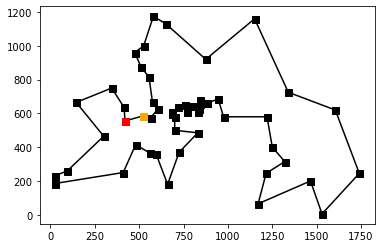

In [37]:
#Deuxième phase: phase de recherche local
Y = pd.read_csv('mydatabase02.txt', sep = '\t') 
Y = Y.values

# Build the Distance Matrix
X = build_distance_matrix(Y)

# Start a Random Seed
seed = seed_function(X)

# Call the Function
lsgrasp = greedy_randomized_adaptive_search_procedure(X, city_tour = seed, iterations = 10, rcl = 15, greediness_value = 0.5)

# Plot Solution. Red Point = Initial city; Orange Point = Second City
plot_tour_coordinates(Y, lsgrasp)